# CUSTOMHyS for Designing Microchannel Heat Sinks

## 0. Packages' installation and loading

In [39]:
%pwd

'C:\\Users\\memo_\\PycharmProjects\\Microchannels'

Instalamos el paquete de Customhys directo del repositorio

In [40]:
!pip3 install install customhys==1.0.1.dev1

You should consider upgrading via the 'C:\Users\memo_\PycharmProjects\Microchannels\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Cargamos los paquetes que vamos a utilizar

In [41]:
import numpy as np
from microchannels import Microchannel
from materials import Copper, Air, Titanium, Aluminium, Graphite, Silicon, AlNF, TiONF, Water
from customhys import metaheuristic as mh

## 1. Microchannel Heat Sink model preparation
En esta parte, preparamos el modelo para utilizarlo y evaluar una configuración de parámetros de diseño en la función objetivo, que en este caso será al generación de entropía.

In [43]:
class MicrochannelDesign():
    def __init__(self):
        self.model = Microchannel(base=Copper(), coolant=Air())
        #self.max_search_range = np.array([self.model.W_d/10, self.model.W_d/10, 0.005])
        #self.min_search_range = np.array([1e-24, 1e-12, 1e-8])

        self.max_search_range = np.array([2.65e-5, 20.4e-5, 0.009])
        self.min_search_range = np.array([4.53e-5, 13.6e-5, 0.005])
        self.func_name = 'Microchannel entropy generation model'

    def get_func_val(self, variables):
        self.model.w_w = variables[0]
        self.model.w_c = variables[1]
        self.model.G_d = variables[2]
        #print(self.model.G_d)
        #print(self.model.alpha)
        #print(self.model.beta)
        return self.model.sgen

    def get_formatted_problem(self, is_constrained=True):
        return dict(function=self.get_func_val,
                    boundaries=(self.min_search_range, self.max_search_range),
                    is_constrained=is_constrained)

fun = MicrochannelDesign()

## 2. Metaheuristic preparation

In [45]:
# Primero cargamos la colección de operadores
with open('./source/collections/' + 'default.txt', 'r') as operators_file:
    heuristic_space = [eval(line.rstrip('\n')) for line in operators_file]

Esta es la parte en donde, utilizando los operadores, ensamblamos la metaheurística a usar:

In [17]:
# Metaheuristic 1: Random Search
# heur = [('random_search', {'scale': 0.01, 'distribution': 'uniform'}, 'greedy')]

# Metaheuristic 2: Particle Swarm & Genetic Linear Crossover with Random Pairing and Metropolis Selection
#heur = [('swarm_dynamic', {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'uniform'}, 'all'),
#        ('genetic_crossover', {'pairing': 'random', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}, 'metropolis')]

heur = [('genetic_crossover',
  {'pairing': 'rank', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4},
  'all'),
        ('swarm_dynamic',
  {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'gaussian'},
  'probabilistic'),
        ('genetic_crossover',
  {'pairing': 'random', 'crossover': 'blend', 'mating_pool_factor': 0.4},
  'probabilistic')]


#Metaheuristic 3: Genetic Algorithm
#heur = [('genetic_crossover', {'pairing': 'tournament_2_100', 'crossover': 'single', 'mating_pool_factor': 0.4}, 'all'), ('genetic_mutation', {'scale': 1.0, 'elite_rate': 0.1, 'mutation_rate': 0.25, 'distribution': 'uniform'}, 'all')]

Aquí terminamos de definirla empleando CUSTOMHyS


In [18]:
met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)

## 3. Run designing process

In [19]:
# Aquí corremos la metaheurística seleccionada
met.verbose = True  # Se puede comentar para que no muestre todo el log
met.run()


Search operators to employ:
genetic_crossover(pairing='rank',crossover='linear_0.5_0.5',mating_pool_factor=0.4) with all
swarm_dynamic(factor=0.7,self_conf=2.54,swarm_conf=2.56,version='inertial',distribution='gaussian') with probabilistic
genetic_crossover(pairing='random',crossover='blend',mating_pool_factor=0.4) with probabilistic
--------------------------------------------------
1
pop. radius: 1.31527382987173
x_best = [2.65e-05 2.04e-04 5.00e-03], f_best = 0.17220071013264232
2
pop. radius: 1.2028263578248464
x_best = [2.65e-05 2.04e-04 5.00e-03], f_best = 0.17220071013264232
3
pop. radius: 0.4792584213432369
x_best = [2.65000000e-05 2.02731196e-04 5.00000000e-03], f_best = 0.1721710424164918
4
pop. radius: 0.034312714391235066
x_best = [2.65000000e-05 2.02753271e-04 5.00000000e-03], f_best = 0.17216668369634008
5
pop. radius: 0.03313183465212277
x_best = [2.65000000e-05 2.02753271e-04 5.00000000e-03], f_best = 0.17216668369634008
6
pop. radius: 0.033184007599444176
x_best = [2.

## 4. Results' visualization

En esta primera gráfica, solo veremos la evolución de la función objetivo (generación de entropía)

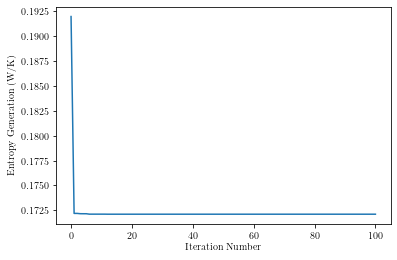

In [20]:
import matplotlib.pyplot as plt

plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation (W/K)')
plt.xlabel(r'Iteration Number')
plt.show()

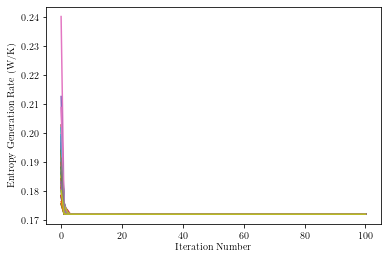

In [21]:
for i in range(1,50):
    met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)
    met.run()
    plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation Rate (W/K)')
plt.xlabel(r'Iteration Number')
plt.gcf()
plt.savefig('resultsMH.jpg')
plt.show()



In [46]:
# from source import experiment as ex
# expe = ex.Experiment()
# expe.hh_configr
# expe.exp_config
# expe.prob_config
# expe.run()
from customhys import hyperheuristic as hh
prob = fun.get_formatted_problem(is_constrained=True)
hyp = None

for i in range(1,2):
    del hyp
    hyp = hh.Hyperheuristic(heuristic_space=heuristic_space, problem=prob, file_label="MC_results_Copper_Air_%d"%i, parameters=
                            dict(cardinality=3,                # Max. numb. of SOs in MHs, lvl:1
                              num_iterations=100,           # Iterations a MH performs, lvl:1
                              num_agents=30,                # Agents in population,     lvl:1
                              num_replicas=30,              # Replicas per each MH,     lvl:2
                              num_steps=100,                # Trials per HH step,       lvl:2
                              stagnation_percentage=0.3,    # Stagnation percentage,    lvl:2
                              max_temperature=200,          # Initial temperature (SA), lvl:2
                              cooling_rate=0.1)
    )
    sol, perf, e_sol = hyp.run()
    print( sol, perf, e_sol, "\n\n")


MC_results_Copper_Air_1 :: Step: 0, Perf: 0.17361096240645799, e-Sol: [195]
MC_results_Copper_Air_1 :: Step: 3, Perf: 0.17211986450293926, e-Sol: [202]
MC_results_Copper_Air_1 :: Step: 33, Perf: 0.17211985470670643, e-Sol: [136 186  85]
MC_results_Copper_Air_1 :: Step: 52, Perf: 0.1721198547066086, e-Sol: [148]
MC_results_Copper_Air_1 :: Step: 83, Perf: 0.17211985470659716, e-Sol: [145]
[['random_flight' {'scale': 1.0, 'distribution': 'gaussian'} 'all']] 0.17211985470659716 [145] 




In [11]:
class MicrochannelDesign():
    def __init__(self):
        self.model = Microchannel(base=Graphite(), coolant=Water())
        #self.max_search_range = np.array([self.model.W_d/10, self.model.W_d/10, 0.005])
        #self.min_search_range = np.array([1e-24, 1e-12, 1e-8])
        self.max_search_range = np.array([2.65e-5, 20.4e-5, 0.009])
        self.min_search_range = np.array([4.53e-5, 13.6e-5, 0.005])
        self.func_name = 'Microchannel entropy generation model'

    def get_func_val(self, variables):
        self.model.w_w = variables[0]
        self.model.w_c = variables[1]
        self.model.G_d = variables[2]
        #print(self.model.G_d)
        #print(self.model.alpha)
        #print(self.model.beta)
        return self.model.sgen

    def get_formatted_problem(self, is_constrained=True):
        return dict(function=self.get_func_val,
                    boundaries=(self.min_search_range, self.max_search_range),
                    is_constrained=is_constrained)

fun = MicrochannelDesign()

In [12]:
from customhys  import hyperheuristic as hh
prob = fun.get_formatted_problem(is_constrained=True)
hyp = None
for i in range(26,31):
    del hyp
    hyp = hh.Hyperheuristic(heuristic_space=heuristic_space, problem=prob, file_label="MC_results2_Graphite_Wat_Ag_50_Stag_10_%d"%i, parameters=
                            dict(cardinality=3,                # Max. numb. of SOs in MHs, lvl:1
                              num_iterations=100,           # Iterations a MH performs, lvl:1
                              num_agents=50,                # Agents in population,     lvl:1
                              num_replicas=30,              # Replicas per each MH,     lvl:2
                              num_steps=100,                # Trials per HH step,       lvl:2
                              stagnation_percentage=0.1,    # Stagnation percentage,    lvl:2
                              max_temperature=200,          # Initial temperature (SA), lvl:2
                              cooling_rate=0.1)
    )
    sol, perf, e_sol = hyp.run()
    print( sol, perf, e_sol, "\n\n")

MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 0, Perf: 108.52248126279315, e-Sol: [110]
MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 1, Perf: 107.49252218594403, e-Sol: [105]
MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 2, Perf: 94.3618260800781, e-Sol: [190 105]
[['swarm_dynamic'
  {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'levy'}
  'greedy']
 ['genetic_crossover'
  {'pairing': 'rank', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}
  'all']] 94.3618260800781 [190 105] 


MC_results2_Graphite_Wat_Ag_50_Stag_10_27 :: Step: 0, Perf: 94.91237108307433, e-Sol: [195]
MC_results2_Graphite_Wat_Ag_50_Stag_10_27 :: Step: 1, Perf: 94.36182203379083, e-Sol: [139 195]
[['random_flight' {'scale': 1.0, 'distribution': 'levy', 'beta': 1.5}
  'metropolis']
 ['swarm_dynamic'
  {'factor': 1.0, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'constriction', 'distribution': 'uniform'}
  'metropolis']] 94.36182203379083 [139 

In [ ]:
parameters=dict(
        cardinality=3,  # Max. numb. of SOs in MHs, lvl:1
        num_iterations=500,  # Iterations a MH performs, lvl:1
        num_agents=300,  # Agents in population,     lvl:1
        num_replicas=30,  # Replicas per each MH,     lvl:2
        num_steps=100,  # Trials per HH step,       lvl:2
        stagnation_percentage=0.5,  # Stagnation percentage,    lvl:2
        max_temperature=200,  # Initial temperature (SA), lvl:2
        cooling_rate=0.05,  # Cooling rate (SA),        lvl:2)
        compute_replicas_in_parallel=False,
        compute_agents_in_parallel=True)

In [6]:
import json
import glob
import os

list_of_files = glob.glob('/path/to/folder/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
# Opening JSON file
with open('data.json') as json_file:
    data = json.load(json_file)

    # for reading nested data [0] represents
    # the index value of the list
    print(data['people1'][0])

    # for printing the key-value pair of
    # nested dictionary for loop can be used
    print("\nPrinting nested dictionary as a key-value pair\n")
    for i in data['people1']:
        print("Name:", i['name'])
        print("Website:", i['website'])
        print("From:", i['from'])
        print()

ValueError: max() arg is an empty sequence

In [33]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

CA_def=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results_Copper_Air_Stag")]
vec=np.empty([30])
file_type = r'\*json'
i=0
for folder in CA_def:
    print(folder)
    list_of_files = glob.glob(folder + file_type)
    print(list_of_files)
    #latest_file = (list_of_files, key=os.path.getmtime)
    print(latest_file)
    with open(latest_file) as json_file:
        data = json.load(json_file)
        vec[i]=data['performance']
    i=i+1

# Creating plot
plt.boxplot(vec)

# show plot
plt.show()
print(vec)

data_files/raw/MC_results_Copper_Air_Stag_10
[]
[]


TypeError: expected str, bytes or os.PathLike object, not list

In [91]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results1_")]
perf=np.empty([20,30])
comb=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf[row,column]=data['performance']
            comb[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf)
print(comb)

data_files/raw/MC_results1_Copper_Air
data_files/raw/MC_results1_Copper_Air_Ag_50
data_files/raw/MC_results1_Copper_Air_Card_2
data_files/raw/MC_results1_Copper_Air_It_50
data_files/raw/MC_results1_Copper_Air_Stag_10
data_files/raw/MC_results1_Copper_Water
data_files/raw/MC_results1_Copper_Water_Ag_50
data_files/raw/MC_results1_Copper_Water_Card_2
data_files/raw/MC_results1_Copper_Water_It_50
data_files/raw/MC_results1_Copper_Water_Stag_10
data_files/raw/MC_results1_Graphite_Air
data_files/raw/MC_results1_Graphite_Air_Ag_50
data_files/raw/MC_results1_Graphite_Air_Card_2
data_files/raw/MC_results1_Graphite_Air_It_50
data_files/raw/MC_results1_Graphite_Air_Stag_10
data_files/raw/MC_results1_Graphite_Water
data_files/raw/MC_results1_Graphite_Water_Ag_50
data_files/raw/MC_results1_Graphite_Water_Card_2
data_files/raw/MC_results1_Graphite_Water_It_50
data_files/raw/MC_results1_Graphite_Water_Stag_10
[[5.82335215e-02 5.82335215e-02 5.82335215e-02 5.82335215e-02
  5.82335292e-02 5.82335215e-0

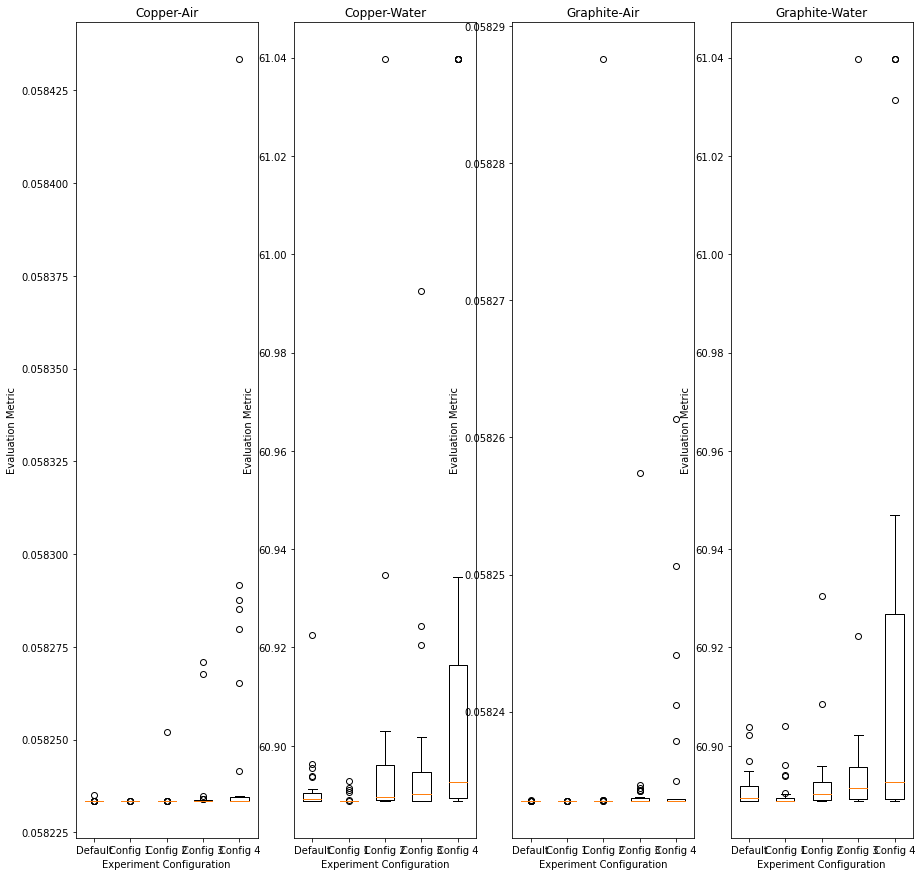

In [92]:
C_A=[perf[0,:],perf[1,:],perf[2,:],perf[3,:],perf[4,:]]
C_W=[perf[5,:],perf[6,:],perf[7,:],perf[8,:],perf[9,:]]
G_A=[perf[10,:],perf[11,:],perf[12,:],perf[13,:],perf[14,:]]
G_W=[perf[15,:],perf[16,:],perf[17,:],perf[18,:],perf[19,:]]

#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(1,4,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(1,4,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(1,4,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(1,4,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH.jpg')
plt.show()



In [ ]:
dat = np.array([C_A,C_W,G_A,G_W])
np.save('data_memo',dat)

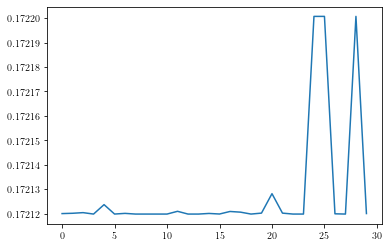

In [8]:
np.set_printoptions(precision=55)
plt.plot(perf[4,:])
plt.show()

In [73]:
folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results3_")]
perf2=np.empty([4,30])
comb2=np.empty([4,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf2[row,column]=data['performance']
            comb2[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf2)
print(comb2)

[[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  -2.43516247e+105  7.94067247e-319  7.59622355e-310  0.00000000e+000
   5.81300869e-307 -2.62115837e-300  0.00000000e+000  4.98512237e-321
   0.00000000e+000 -5.72778463e+250 -1.26589957e-255  1.04606154e+115
   1.46634507e+253 -7.21106271e+038  5.17770658e-312 -1.80481569e+058
   1.48302050e-309 -4.27244870e+096  9.79173817e-310  2.19180935e-193
  -5.82689024e+250  3.53888377e-305 -5.77368711e+250  4.55695127e-304
   2.63402137e-307 -2.00046539e+000]
 [ 2.00117682e-306 -5.09908038e-057 -6.62643619e-029  5.86081585e-255
  -2.30489446e-159  8.91898525e-150  4.09967960e-312  4.78117523e-299
   4.55700602e-304  2.59766981e-265  4.55706544e-304  9.43453467e-315
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  -5.48612774e+303  1.11375059e-308  2.93885068e-319  2.10951042e+000
  -1.53743208e-154 -2.60275885e+016 -6.56122420e-142 -8.08634922e-174
  -5.48624431e+303  1.34800613e-314  1.61425080e-318 

In [15]:
C_A=[perf[0,:],perf[1,:],perf[4,:],perf2[0,:]]
C_W=[perf[5,:],perf[6,:],perf[9,:],perf2[1,:]]
G_A=[perf[10,:],perf[11,:],perf[14,:],perf2[2,:]]
G_W=[perf[15,:],perf[16,:],perf[19,:],perf2[3,:]]

labels = ['Default', '50 Agents','10 Stagnation','AG-Stag']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
plt.gcf()
plt.savefig('resultsHH2.jpg')
plt.show()


NameError: name 'perf2' is not defined

In [79]:
index=np.empty([1,20])
operators=np.empty([1,20])
for i in range(0,20):
    y=perf[i,:]
    x=np.argmin(y)
    index[0,i]=x
print(index)

[[ 0.  0.  0.  2.  0.  3.  2.  7.  1. 22.  2.  0.  0.  7.  0.  7.  6.  9.
   5.  5.]]


In [80]:
ind_best_perf = np.argmin(perf, axis=1)
best_mhs = [comb[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[97, 180, 21],
 [57, 145],
 [46, 148],
 [18, 180, 98],
 [21, 54, 150],
 [104, 174, 7],
 [59, 178, 146],
 [147, 178],
 [139, 98, 177],
 [178, 200],
 [117, 199, 158],
 [148, 63, 100],
 [26, 94],
 [137, 104, 28],
 [20, 97],
 [146, 180],
 [180, 83, 201],
 [18, 179],
 [174, 16, 100],
 [177, 6]]

In [121]:
best_mhs

[[157, 195],
 [34],
 [10, 40],
 [140],
 [5, 195, 119],
 [193, 148],
 [138],
 [14],
 [126, 137, 90],
 [105, 145],
 [80, 128, 204],
 [158],
 [39, 6],
 [204, 177],
 [25],
 [87, 176],
 [148, 90],
 [30, 193],
 [131],
 [165, 24]]

In [139]:
x=comb[19]
print(x)

[list([127]) list([174, 59]) list([201]) list([174]) list([134])
 list([10]) list([51]) list([200]) list([166]) list([174]) list([4])
 list([86]) list([119]) list([90, 176]) list([59]) list([124]) list([53])
 list([181]) list([18]) list([165, 24]) list([115]) list([145])
 list([204]) list([53]) list([104]) list([63]) list([47]) list([7])
 list([119]) list([104])]


In [81]:
ac_tot=[]

for y in range(0,len(comb)):
    arr_tot= np.array(comb[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)


[ 97 180  21 ... 140 187  85]


In [82]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '126', '127', '128', '129', '130', '131', '132', '134', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '155', '156', '157', '158', '159', '160', '161', '162', '163', 

In [83]:
fam=['random search','central force dynamic','differential mutation','firefly dynamic','genetic crossover','genetic mutation','gravitational search','random flight','local random walk','random sample','spiral dynamic','swarm dynamic']
frec2=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] == 0:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 1 and num2[i] <= 4:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 5 and num2[i] <= 28:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] >= 29 and num2[i] <= 40:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 41 and num2[i] <= 120:
        frec2[4]= frec2[4] + frec[i]
    elif num2[i] >= 121 and num2[i] <= 132:
        frec2[5]= frec2[5] + frec[i]
    elif num2[i] >= 133 and num2[i] <= 136:
        frec2[6]= frec2[6] + frec[i]
    elif num2[i] >= 137 and num2[i] <= 148:
        frec2[7]= frec2[7] + frec[i]
    elif num2[i] >= 149 and num2[i] <= 160:
        frec2[8]= frec2[8] + frec[i]
    elif num2[i] >= 161 and num2[i] <= 164:
        frec2[9]= frec2[9] + frec[i]
    elif num2[i] >= 165 and num2[i] <= 176:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 177 and num2[i] <= 180:
        frec2[10]= frec2[10] + frec[i]
    elif num2[i] >= 181 and num2[i] <= 204:
        frec2[11]= frec2[11] + frec[i]
print(frec2)
print(fam)


[89, 7, 206, 50, 376, 35, 11, 218, 67, 13, 45, 283]
['random search', 'central force dynamic', 'differential mutation', 'firefly dynamic', 'genetic crossover', 'genetic mutation', 'gravitational search', 'random flight', 'local random walk', 'random sample', 'spiral dynamic', 'swarm dynamic']


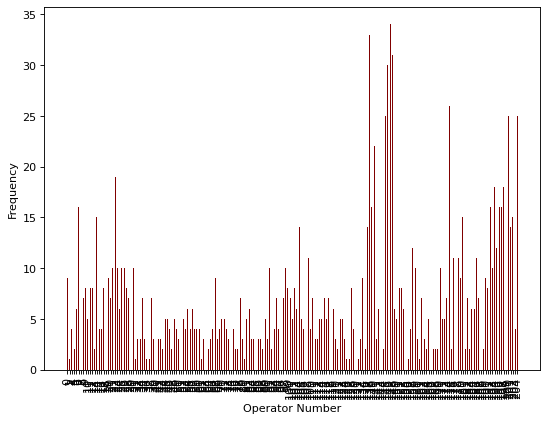

In [84]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG1.jpg')
plt.show()

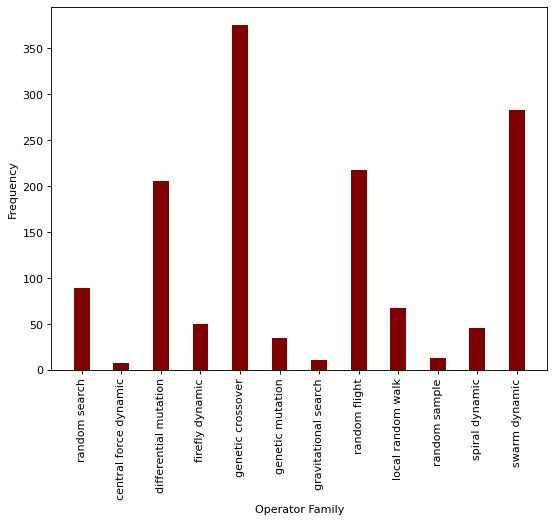

In [85]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG2.jpg',bbox_inches='tight')
plt.show()

In [86]:
arr = np.array(best_mhs, dtype=object)
ac=[]

for i in range(0,len(arr)):
    w=np.array(arr[i])
    for z in range(0,len(w)):
        ac.append(w[z])

ac=np.array(ac)
print(ac)



[ 97 180  21  57 145  46 148  18 180  98  21  54 150 104 174   7  59 178
 146 147 178 139  98 177 178 200 117 199 158 148  63 100  26  94 137 104
  28  20  97 146 180 180  83 201  18 179 174  16 100 177   6]


In [87]:
sorted=np.sort(ac);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['6', '7', '16', '18', '20', '21', '26', '28', '46', '54', '57', '59', '63', '83', '94', '97', '98', '100', '104', '117', '137', '139', '145', '146', '147', '148', '150', '158', '174', '177', '178', '179', '180', '199', '200', '201']
[6, 7, 16, 18, 20, 21, 26, 28, 46, 54, 57, 59, 63, 83, 94, 97, 98, 100, 104, 117, 137, 139, 145, 146, 147, 148, 150, 158, 174, 177, 178, 179, 180, 199, 200, 201]
[1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 3, 1, 4, 1, 1, 1]


In [88]:
fam=['random search','central force_dynamic','differential mutation','firefly dynamic','genetic crossover','genetic mutation','gravitational search','random flight','local random_walk','random sample','spiral dynamic','swarm dynamic']
frec2=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] == 0:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 1 and num2[i] <= 4:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 5 and num2[i] <= 28:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] >= 29 and num2[i] <= 40:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 41 and num2[i] <= 120:
        frec2[4]= frec2[4] + frec[i]
    elif num2[i] >= 121 and num2[i] <= 132:
        frec2[5]= frec2[5] + frec[i]
    elif num2[i] >= 133 and num2[i] <= 136:
        frec2[6]= frec2[6] + frec[i]
    elif num2[i] >= 137 and num2[i] <= 148:
        frec2[7]= frec2[7] + frec[i]
    elif num2[i] >= 149 and num2[i] <= 160:
        frec2[8]= frec2[8] + frec[i]
    elif num2[i] >= 161 and num2[i] <= 164:
        frec2[9]= frec2[9] + frec[i]
    elif num2[i] >= 165 and num2[i] <= 176:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 177 and num2[i] <= 180:
        frec2[10]= frec2[10] + frec[i]
    elif num2[i] >= 181 and num2[i] <= 204:
        frec2[11]= frec2[11] + frec[i]
print(frec2)
print(fam)


[2, 0, 10, 0, 16, 0, 0, 8, 2, 0, 10, 3]
['random search', 'central force_dynamic', 'differential mutation', 'firefly dynamic', 'genetic crossover', 'genetic mutation', 'gravitational search', 'random flight', 'local random_walk', 'random sample', 'spiral dynamic', 'swarm dynamic']


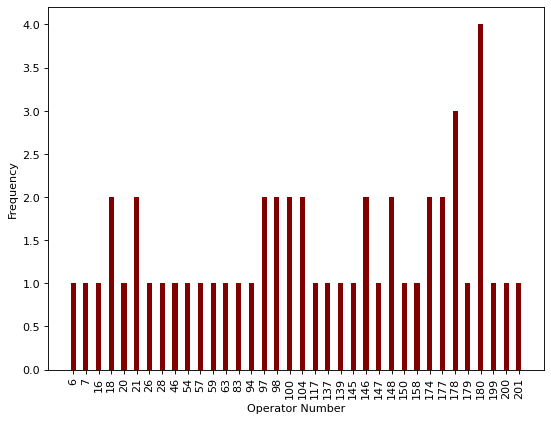

In [89]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG3.jpg')
plt.show()

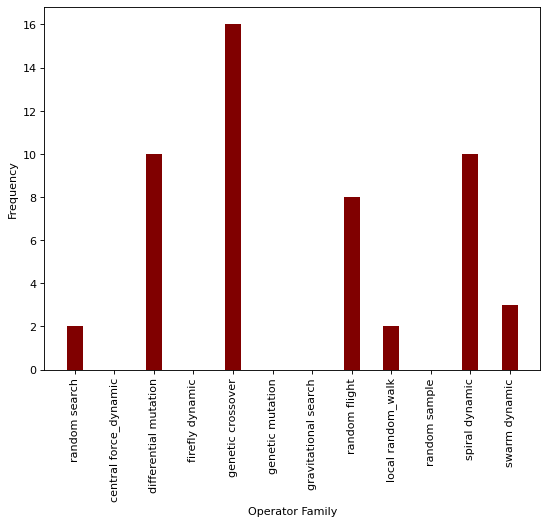

In [90]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG4.jpg',bbox_inches='tight')
plt.show()

In [29]:
arr = np.array(best_mhs, dtype=object)
arr = np.transpose(arr)
arr.shape

(20,)

In [44]:

x=np.array(arr[0])
x[0]

157

In [63]:
ac=np.zeros(shape=(1, len(arr)))
print(ac)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [81]:
test=np.array([1,2,3])
test=np.delete(test,1)
h=len(test)
print(test)

[1 3]


In [100]:
heuristic_space

[('random_search', {'scale': 1.0, 'distribution': 'uniform'}, 'greedy'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'all'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'greedy'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'metropolis'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'probabilistic'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'all'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'greedy'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'metropolis'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'probabilistic'),
 ('differential_mutation',
  {'expression': 'best', 'num_rands': 1, 'factor': 1.0},
  'all'),
 ('differential_mutation'

In [80]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
index = [2, 3, 6]

new_a = np.delete(a, index)

print(new_a)

[1 2 5 6 8 9]


In [38]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results6_")]
perf4=np.empty([20,30])
comb4=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf4[row,column]=data['performance']
            comb4[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf4)
print(comb4)

data_files/raw/MC_results6_Copper_Air
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_1\35-01_24_2023_08_05_43.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_10\6-01_24_2023_09_08_39.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_11\7-01_24_2023_09_14_53.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_12\34-01_24_2023_09_25_18.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_13\13-01_24_2023_09_31_49.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_14\4-01_24_2023_09_38_17.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_15\4-01_24_2023_09_44_55.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_16\22-01_24_2023_09_53_47.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_17\4-01_24_2023_09_58_37.json
data_files/raw/MC_results6_Copper_Air/MC_results6_Copper_Air_18\65-01_24_2023_10_14_49.json
data_files/raw/MC_results6_Copper_Air/MC_results

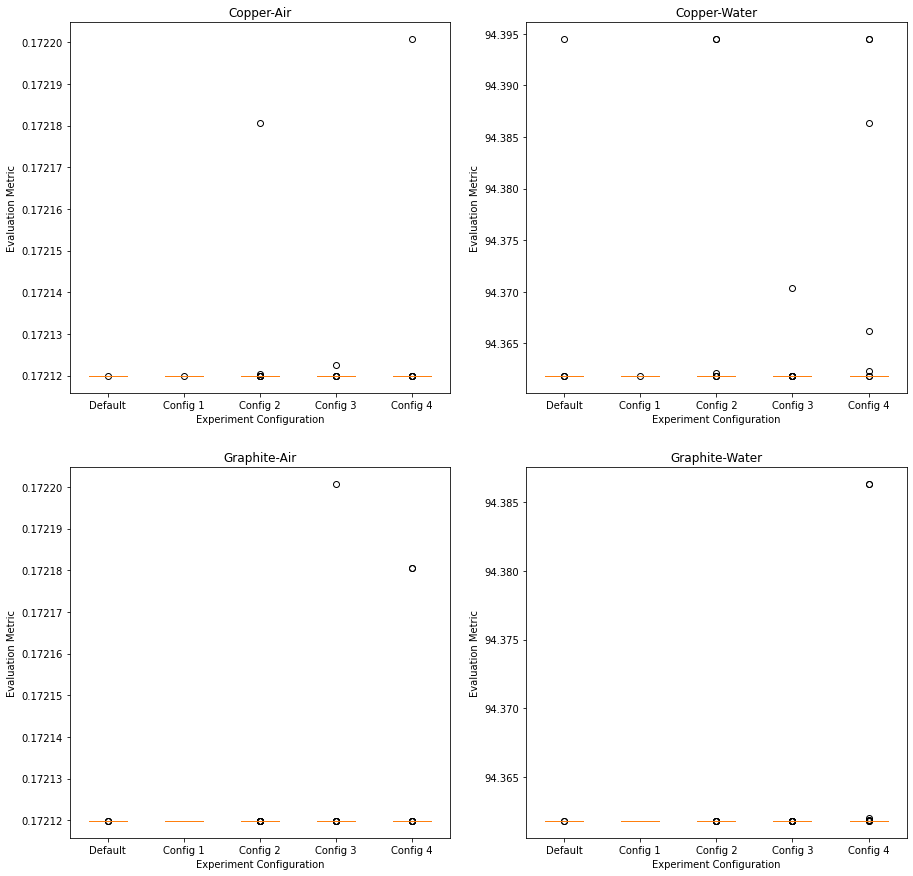

In [39]:
C_A=[perf4[0,:],perf4[1,:],perf4[2,:],perf4[3,:],perf4[4,:]]
C_W=[perf4[5,:],perf4[6,:],perf4[7,:],perf4[8,:],perf4[9,:]]
G_A=[perf4[10,:],perf4[11,:],perf4[12,:],perf4[13,:],perf4[14,:]]
G_W=[perf4[15,:],perf4[16,:],perf4[17,:],perf4[18,:],perf4[19,:]]


#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH2.jpg')
plt.show()


In [40]:
dat = np.array([C_A,C_W,G_A,G_W])
np.save('data_memo',dat)

In [41]:
index4=np.empty([1,20])
operators4=np.empty([1,20])
for i in range(0,20):
    y=perf4[i,:]
    x=np.argmin(y)
    index4[0,i]=x
print(index4)

[[0. 0. 0. 1. 0. 0. 0. 1. 7. 1. 0. 0. 0. 2. 0. 0. 0. 2. 1. 1.]]


In [42]:
ind_best_perf = np.argmin(perf4, axis=1)
best_mhs = [comb4[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[28, 27, 11],
 [28, 26, 16],
 [17, 31],
 [29, 26, 33],
 [30, 15, 8],
 [15, 20],
 [32, 7, 13],
 [31, 13],
 [26, 33],
 [28, 18, 13],
 [26, 32],
 [20, 15],
 [27, 20],
 [6, 31, 29],
 [31, 4],
 [11, 19],
 [26, 28],
 [14, 30],
 [21, 9, 31],
 [15, 19]]

In [43]:
ac_tot=[]

for y in range(0,len(comb4)):
    arr_tot= np.array(comb4[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)

[28 27 11 ... 12 31 14]


In [44]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[20, 21, 12, 2, 24, 15, 32, 28, 13, 41, 46, 33, 32, 47, 39, 28, 32, 34, 36, 68, 67, 82, 10, 16, 17, 12, 109, 78, 73, 51, 82, 87, 61, 67]


In [45]:
fam=['differential mutation','genetic crossover','random flight','spiral dynamic','swarm dynamic']
frec2=[0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] >= 0 and num2[i] <= 3:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 4 and num2[i] <= 17:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 18 and num2[i] <= 21:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] >= 22 and num2[i] <= 25:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 26 and num2[i] <= 33:
        frec2[4]= frec2[4] + frec[i]

print(frec2)
print(fam)

[55, 444, 253, 55, 608]
['differential mutation', 'genetic crossover', 'random flight', 'spiral dynamic', 'swarm dynamic']


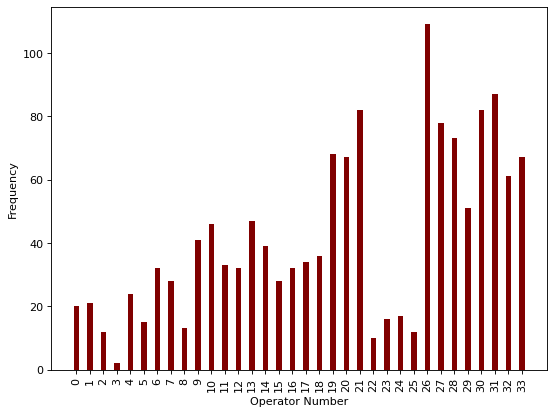

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG5.jpg')
plt.show()

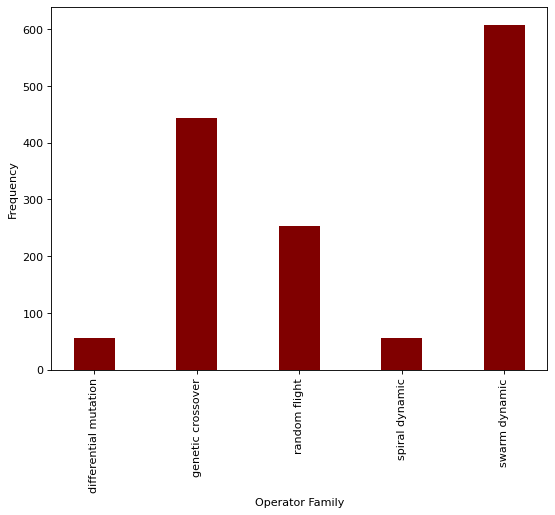

In [21]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG6.jpg',bbox_inches='tight')
plt.show()

In [59]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results7_")]
perf5=np.empty([20,30])
comb5=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf5[row,column]=data['performance']
            comb5[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf5)
print(comb5)

data_files/raw/MC_results7_Copper_Air
data_files/raw/MC_results7_Copper_Air_Ag_50
data_files/raw/MC_results7_Copper_Air_Card_2
data_files/raw/MC_results7_Copper_Air_It_50
data_files/raw/MC_results7_Copper_Air_Stag_10
data_files/raw/MC_results7_Copper_Wat
data_files/raw/MC_results7_Copper_Wat_Ag_50
data_files/raw/MC_results7_Copper_Wat_Card_2
data_files/raw/MC_results7_Copper_Wat_It_50
data_files/raw/MC_results7_Copper_Wat_Stag_10
data_files/raw/MC_results7_Graphite_Air
data_files/raw/MC_results7_Graphite_Air_Ag_50
data_files/raw/MC_results7_Graphite_Air_Card_2
data_files/raw/MC_results7_Graphite_Air_It_50
data_files/raw/MC_results7_Graphite_Air_Stag_10
data_files/raw/MC_results7_Graphite_Wat
data_files/raw/MC_results7_Graphite_Wat_Ag_50
data_files/raw/MC_results7_Graphite_Wat_Card_2
data_files/raw/MC_results7_Graphite_Wat_It_50
data_files/raw/MC_results7_Graphite_Wat_Stag_10
[[ 0.17211985  0.17211985  0.17211985  0.17211985  0.17211985  0.17211985
   0.17211985  0.17211985  0.17211985 

In [60]:
import statistics
names=["CA","CA_AG","CA_CARD","CA_IT","CA_STAG","CW","CW_AG","CW_CARD","CW_IT","CW_STAG","GA","GA_AG","GA_CARD","GA_IT","GA_STAG","GW","GW_AG","GW_CARD","GW_IT","GW_STAG"]
for i in range(0,20):
    print(names[i])
    average = sum(perf5[i,:])/len(perf5[i,:])
    print("Average of list: ",average)
    sdv=statistics.stdev(perf5[i,:])
    print("Standart Deviation: ", sdv)
    cv= sdv/average
    print("CV: ", cv)
    print("")
    print("")

CA
Average of list:  0.17211985470659324
Standart Deviation:  0.0
CV:  0.0


CA_AG
Average of list:  0.17211985470659324
Standart Deviation:  0.0
CV:  0.0


CA_CARD
Average of list:  0.17211985470659324
Standart Deviation:  0.0
CV:  0.0


CA_IT
Average of list:  0.17211985471143762
Standart Deviation:  2.6529299002527405e-11
CV:  1.5413270622964624e-10


CA_STAG
Average of list:  0.17211985473646674
Standart Deviation:  1.6362391325457352e-10
CV:  9.506393873333127e-10


CW
Average of list:  94.3618220593968
Standart Deviation:  0.0
CV:  0.0


CW_AG
Average of list:  94.3618220593968
Standart Deviation:  0.0
CV:  0.0


CW_CARD
Average of list:  94.3618220593968
Standart Deviation:  0.0
CV:  0.0


CW_IT
Average of list:  94.36182205941483
Standart Deviation:  9.718663624163069e-11
CV:  1.0299359859799783e-12


CW_STAG
Average of list:  94.36182205939681
Standart Deviation:  3.115305608245512e-14
CV:  3.301447068587291e-16


GA
Average of list:  0.17211983831426717
Standart Deviation:  0

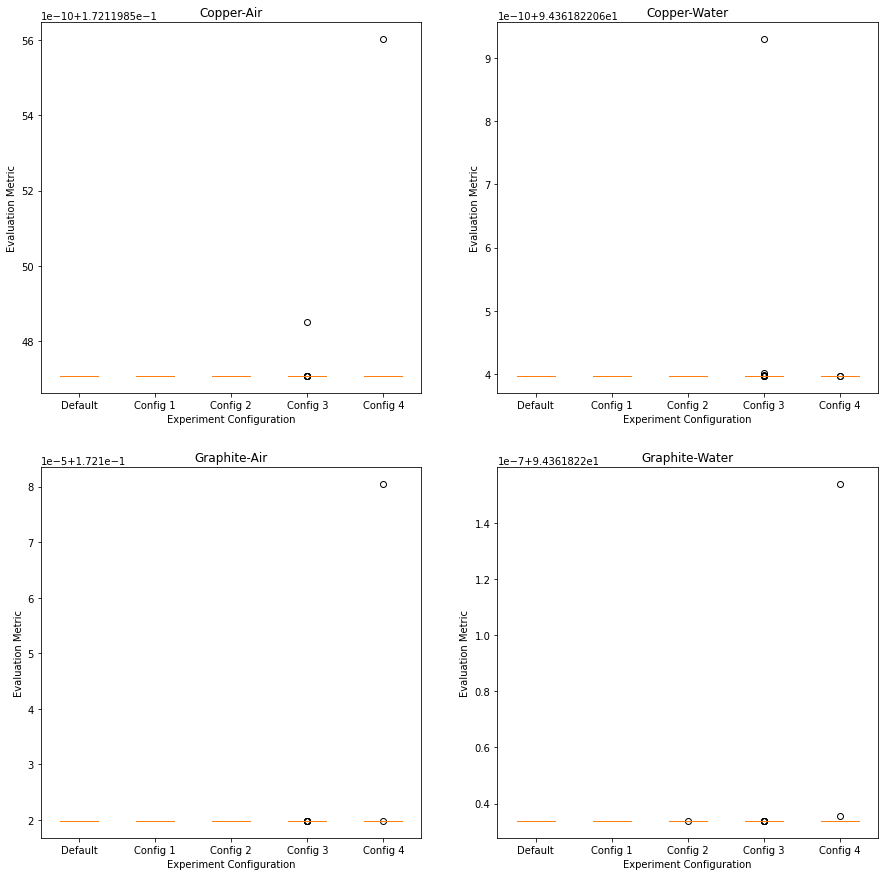

In [53]:
C_A=[perf5[0,:],perf5[1,:],perf5[2,:],perf5[3,:],perf5[4,:]]
C_W=[perf5[5,:],perf5[6,:],perf5[7,:],perf5[8,:],perf5[9,:]]
G_A=[perf5[10,:],perf5[11,:],perf5[12,:],perf5[13,:],perf5[14,:]]
G_W=[perf5[15,:],perf5[16,:],perf5[17,:],perf5[18,:],perf5[19,:]]


#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH3.jpg')
plt.show()

In [54]:
dat = np.array([C_A,C_W,G_A,G_W])
np.save('data_memo',dat)

In [26]:
index5=np.empty([1,20])
operators5=np.empty([1,20])
for i in range(0,20):
    y=perf5[i,:]
    x=np.argmin(y)
    index5[0,i]=x
print(index5)

[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0.]]


In [65]:
ind_best_perf = np.argmin(perf5, axis=1)
best_mhs = [comb5[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[2, 8],
 [11, 6],
 [3, 7],
 [8, 5, 6],
 [6, 13],
 [7, 10, 5],
 [13, 7, 10],
 [11, 2],
 [3, 0, 11],
 [7, 9],
 [2, 12, 1],
 [2, 5],
 [6, 11],
 [9, 2, 10],
 [12, 7],
 [8, 7],
 [2, 10],
 [12, 7],
 [3, 2, 11],
 [11, 2, 7]]

In [69]:
a= 0.1721225498874615
s= 1.4513993160849943e-05
x=s/a
print(x)

8.43236006574362e-05


In [28]:
ac_tot=[]

for y in range(0,len(comb5)):
    arr_tot= np.array(comb5[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)

[ 2  8  5 ...  1 12  0]


In [29]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[76, 46, 118, 92, 76, 108, 197, 183, 93, 66, 95, 94, 71, 92]


In [31]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[76, 46, 118, 92, 76, 108, 197, 183, 93, 66, 95, 94, 71, 92]


In [32]:
fam=['genetic crossover','random flight','swarm dynamic']
frec2=[0,0,0]
for i in range(0,len(num2)):
    if num2[i] >= 0 and num2[i] <= 2:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 3 and num2[i] <= 5:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 6 and num2[i] <= 13:
        frec2[2]= frec2[2] + frec[i]

print(frec2)
print(fam)

[240, 276, 891]
['genetic crossover', 'random flight', 'swarm dynamic']


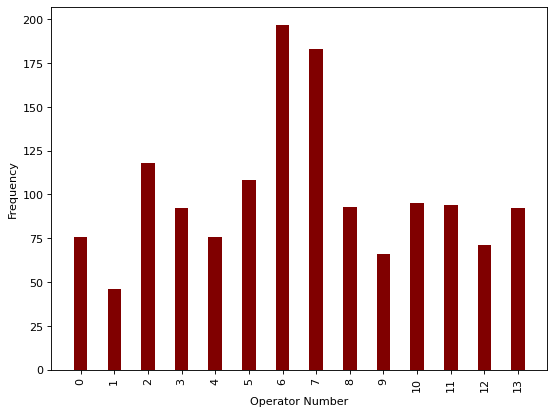

In [33]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG7.jpg')
plt.show()

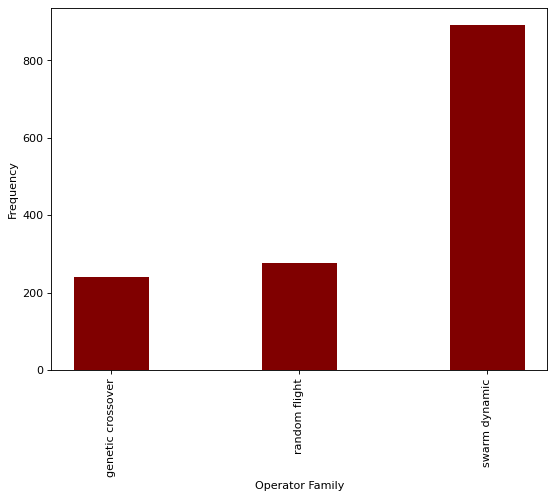

In [34]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG8.jpg',bbox_inches='tight')
plt.show()